# Signature Authentication Model

### Let's unzip our data first

In [1]:
!unzip /content/drive/MyDrive/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-17.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-18.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-19.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-20.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-21.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-22.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-23.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-24.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-25.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-26.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-27.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-28.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-29.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-30.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-G-01.tif  
  inflating: BHSig2

In [84]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Concatenate
from keras.layers import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.layers import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import regularizers

from sklearn.metrics import confusion_matrix
import seaborn as sns

### Let's create the CEDAR Data first

In [3]:
path_to_cedar = "/content/CEDAR/CEDAR/"

In [4]:
def integer_sort(folder_path):
  """
  Sorts folder names numerically while preserving their original order.

  Args:
      folder_path: The path to the folder containing numbered subfolders.

  Returns:
      A list of folder names sorted numerically.
  """
  entries = os.listdir(folder_path)
  entries.sort(key=lambda a: int(a.split(".")[0]))  # Split and get the number before extension (if any)
  return entries

In [5]:
dir_list = integer_sort(path_to_cedar)

In [6]:
len(dir_list)

55

In [7]:
def generate_cedar_data(folder_path):
  """
  Separates forged and genuine image paths within numbered folders.

  Args:
      folder_path: The path to the folder containing numbered subfolders.

  Returns:
      A dictionary containing two lists:
          - 'forged': Paths to all forged images in each folder.
          - 'genuine': Paths to all genuine images in each folder.
  """
  forged_group, orig_group = [], []  #final lists

  for folder in integer_sort(folder_path):  # Use integer_sort for folder order
    forged, genuine = [], []
    folder_path_full = os.path.join(folder_path, folder)
    for entry in os.listdir(folder_path_full):
      if entry.startswith("forgeries_"):
        forged.append(os.path.join(folder_path_full, entry))
      elif entry.startswith("original_"):
        genuine.append(os.path.join(folder_path_full, entry))
    forged_group.append(forged)
    orig_group.append(genuine)
  return {'forged': forged_group, 'genuine': orig_group}

In [8]:
result = generate_cedar_data(path_to_cedar)

In [9]:
forged_groups = result['forged']
genuine_groups = result['genuine']

In [10]:
len(genuine_groups[0]), len(forged_groups[0])

(24, 24)

### Let's create the Bengali Data now

In [11]:
path_to_bengali = "/content/BHSig260-Bengali/BHSig260-Bengali"

In [12]:
ben_dir_list = integer_sort(folder_path=path_to_bengali)

In [13]:
len(ben_dir_list)

100

In [14]:
ben_dir_list[-10:]

['91', '92', '93', '94', '95', '96', '97', '98', '99', '100']

In [15]:
def generate_bhsig20_data(folder_path):
  forged_group, orig_group = [], []  #final lists

  for folder in integer_sort(folder_path):  # Use integer_sort for folder order
    forged, genuine = [], []
    folder_path_full = os.path.join(folder_path, folder)
    for entry in os.listdir(folder_path_full):
      img_type = entry.split('/')[-1].split('-')[3]
      if img_type =='F':
        forged.append(os.path.join(folder_path_full, entry))
      else:
        genuine.append(os.path.join(folder_path_full, entry))

    forged_group.append(forged)
    orig_group.append(genuine)
  return {'forged': forged_group, 'genuine': orig_group}

In [16]:
result = generate_bhsig20_data(path_to_bengali)

In [17]:
bengali_forged_group = result['forged']
len(bengali_forged_group)

100

In [18]:
bengali_original_group = result['genuine']
len(bengali_original_group)

100

In [19]:
path_to_hindi = "/content/BHSig260-Hindi/BHSig260-Hindi"

In [20]:
result = generate_bhsig20_data(folder_path = path_to_hindi)

In [21]:
hindi_forged_group = result['forged']
len(hindi_forged_group)

160

In [22]:
hindi_genuine_group = result['genuine']
len(hindi_genuine_group)

160

### Making the final dataset

In [23]:
FORGED_GROUPS = forged_groups + bengali_forged_group + hindi_forged_group

In [24]:
ORIGINAL_GROUPS = genuine_groups + bengali_original_group + hindi_genuine_group

# Spliting the data

*   60-20-20 Split for train, validation and test.
*   189 signatures for training, 63 for validation and 63 for test

In [25]:
orig_train = ORIGINAL_GROUPS[:33] + ORIGINAL_GROUPS[55:55+60] + ORIGINAL_GROUPS[155:155+96]
forg_train = FORGED_GROUPS[:33] + FORGED_GROUPS[55:55+60] + FORGED_GROUPS[155:155+96]

In [26]:
orig_val = ORIGINAL_GROUPS[33:44] + ORIGINAL_GROUPS[115:135] + ORIGINAL_GROUPS[251: 283]
forg_val = FORGED_GROUPS[33:44] + FORGED_GROUPS[115:135] + FORGED_GROUPS[251: 283]

In [27]:
orig_test = ORIGINAL_GROUPS[44:55] + ORIGINAL_GROUPS[135:155] + ORIGINAL_GROUPS[283: 315]
forg_test = FORGED_GROUPS[44:55] + FORGED_GROUPS[135:155] + FORGED_GROUPS[283: 315]

In [29]:
cedar_orig_train, cedar_orig_val, cedar_orig_test = ORIGINAL_GROUPS[:33] , ORIGINAL_GROUPS[33:44], ORIGINAL_GROUPS[44:55]
cedar_forg_train, cedar_forg_val, cedar_forg_test = FORGED_GROUPS[:33] , FORGED_GROUPS[33:44], FORGED_GROUPS[44:55]

### Setting the image shape. Decided to go for (224,224)

In [28]:
img_w = 224
img_h = 224

### Data Visualization

In [30]:
def see_example():
    '''
    Function to randomly select a signature from train set and
    print two genuine copies and one forged copy
    '''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Real Version')
    ax2.set_title('G')
    ax3.set_title('F')

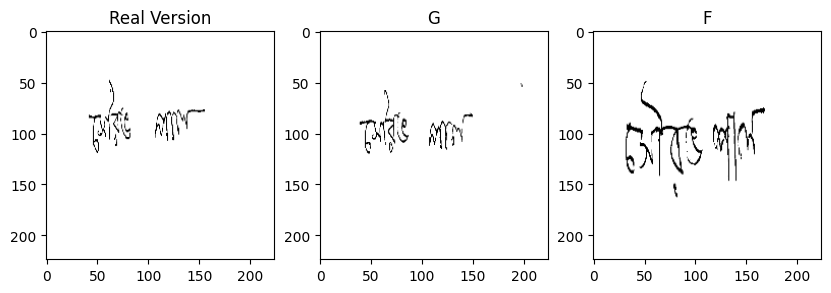

In [31]:
see_example()

# Pairs Creation for Siamese Neural Network

*   The idea is to create pairs of Genuine-Genuine image names and Genuine-Forged image names.
*   Per person we have 24 original signatures, so we have to create 24x24 = 276 G-G Pairs.
*    To make G-F pairs, we pair every Genuine signature of a person
with 12 randomly sampled Forged signatures of the same person. Thus we make 24 x12 = 300 G-F image pairs for one person.


### Data in numbers
In all we have 315 person's data in the training data.

*   Total no. of Genuine-Genuine pairs = 315x276 = 86940
*   Total number of Genuine-Forged pairs = 315x300 = 94500
*   Total no. of data points = 86940 + 94500 = 69120



##### Note:
*We chose 12 random forged signatures because we do not want there to a be class imbalance between g-g and g-f pairs.*


In [32]:
def generate_batch(orig_groups, forg_groups, batch_size=32):
    '''
    Function to generate a batch of data with batch_size number of data points.

    Args:
        orig_groups (list of lists): A list of lists where each sublist contains file paths or identifiers for genuine signatures.
        forg_groups (list of lists): A list of lists where each sublist contains file paths or identifiers for forged signatures.
        batch_size (int, optional): The number of data points (pairs of genuine-genuine or genuine-forged signatures) to include in each batch of data generated by the function. Default is 32.

    Yields:
        tuple: A tuple containing:
            - list: A list of two NumPy arrays representing pairs of images (genuine-genuine or genuine-forged).
            - NumPy array: An array containing the corresponding labels for the pairs (1 for genuine-genuine pairs, 0 for genuine-forged pairs).
    '''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []

        # Generating pairs
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))

        # Label for Genuine-Genuine pairs is 1, for Genuine-Forged pairs is 0
        gen_gen_labels = [1] * len(orig_pairs)
        gen_for_labels = [0] * len(forg_pairs)

        # Concatenating pairs and labels and shuffling
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)

        # Yielding batches
        # Below yield the batch,in each batch we load "batch_size" number of image pairs.These images are then removed from the original set so that they are not added again.
        k = 0
        pairs = [np.zeros((batch_size, img_h, img_w, 1)) for _ in range(2)]
        targets = np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype=np.float64)
            img2 = np.array(img2, dtype=np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs = [np.zeros((batch_size, img_h, img_w, 1)) for _ in range(2)]
                targets = np.zeros((batch_size,))


## Creating the euclidean distance and loss function (referred the github repo mentioned in the deliverable document )

In [33]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [34]:
def eucl_dist_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

In [35]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


# Siamese Neural Network Model

In [54]:
def create_base_network_signet(input_shape):
    '''
    Base Siamese Network.

    Args:
        input_shape (tuple): The shape of input images (height, width, channels).

    Returns:
        Sequential: A Sequential model representing the base Siamese network.
    '''

    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape,
                        kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(ZeroPadding2D((2, 2), data_format='channels_last'))

    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform',  data_format='channels_last'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1), data_format='channels_last'))

    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform',  data_format='channels_last'))
    seq.add(ZeroPadding2D((1, 1), data_format='channels_last'))

    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, kernel_regularizer=regularizers.l2(0.0005), activation='relu'))
    seq.add(Dropout(0.5))
    seq.add(Dense(128, kernel_regularizer=regularizers.l2(0.0005), activation='relu'))

    return seq

In [55]:
input_shape=(img_h, img_w, 1)

# We define the network
## As we re-use the same instance `base_network`,the weights of the network will be shared across the two branches.

In [56]:
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))


processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])


In [57]:
model = Model([input_a, input_b], distance)

In [ ]:
batch_sz = 128
num_train_samples = 276*189 + 300*189
num_val_samples = num_test_samples = 276*63 + 300*63
num_train_samples, num_val_samples, num_test_samples

(108864, 36288, 36288)

# Model Compilation using RMSProp Optimizer and Contrastive loss function

In [60]:
rms = RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./Weights/signet-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

# Hyperparameter Tuning
We can alter the following parameters for getting the best accuracy.

*   Learning Rate
*   Number of Epochs
*   Early Stopping



# For predicting on the entire processed data:

In [ ]:
results = model.fit(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 50,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

## Training on Cedar Data

In [ ]:
cedar_batch_sz = 32
cedar_num_train_samples = 276*33 + 300*33
cedar_num_val_samples = cedar_num_test_samples = 276*11 + 300*11
cedar_num_train_samples, cedar_num_val_samples, cedar_num_test_samples

results = model.fit(generate_batch(cedar_orig_train, cedar_forg_train, cedar_batch_sz),
                              steps_per_epoch = cedar_num_train_samples//cedar_batch_sz,
                              epochs = 10,
                              validation_data = generate_batch(cedar_orig_val, cedar_forg_val, cedar_batch_sz),
                              validation_steps = cedar_num_val_samples//cedar_batch_sz,
                              callbacks = callbacks)

## Training on the Bengali Data

In [ ]:
# bengali_batch_sz = 64
# bengali_num_train_samples = 276*60 + 300*60
# bengali_num_val_samples = bengali_num_test_samples = 276*20 + 300*20
# bengali_num_train_samples, bengali_num_val_samples, bengali_num_test_samples

# results = model.fit(generate_batch(bengali_orig_train, bengali_forg_train, bengali_batch_sz),
#                               steps_per_epoch = bengali_num_train_samples//bengali_batch_sz,
#                               epochs = 10,
#                               validation_data = generate_batch(bengali_orig_val, bengali_forg_val, bengali_batch_sz),
#                               validation_steps = bengali_num_val_samples//bengali_batch_sz,
#                               callbacks = callbacks)


## Training on Hindi Data

In [ ]:
# hindi_batch_sz = 128
# hindi_num_train_samples = 276*96 + 300*96
# hindi_num_val_samples = hindi_num_test_samples = 276*32 + 300*32
# hindi_num_train_samples, hindi_num_val_samples, hindi_num_test_samples

# results = model.fit(generate_batch(hindi_orig_train, hindi_forg_train, hindi_batch_sz),
#                               steps_per_epoch = hindi_num_train_samples//hindi_batch_sz,
#                               epochs = 100,
#                               validation_data = generate_batch(hindi_orig_val, hindi_forg_val, hindi_batch_sz),
#                               validation_steps = hindi_num_val_samples//hindi_batch_sz,
#                               callbacks = callbacks)

In [45]:
def compute_accuracy_roc(predictions, labels):
    '''
    Compute ROC accuracy with a range of thresholds on distances.

    Args:
        predictions (numpy.ndarray): Predicted distances between pairs.
        labels (numpy.ndarray): Ground truth labels indicating genuine (1) or forged (0) pairs.

    Returns:
        tuple: A tuple containing the maximum accuracy achieved and the corresponding optimal threshold.
    '''
    import numpy as np

    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)

    step = 0.01
    max_acc = 0
    best_thresh = -1

    for d in np.arange(dmin, dmax + step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d

        tpr = float(np.sum(labels[idx1] == 1)) / nsame
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)

        if acc > max_acc:
            max_acc, best_thresh = acc, d

    return max_acc, best_thresh


## Prediction Time

In [64]:
model.load_weights('./Weights/signet-001.h5')

In [65]:
test_gen = generate_batch(cedar_orig_test, cedar_forg_test, 1)
pred, tr_y = [], []
for i in range(cedar_num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 35ms/step


# Accuracy and Threshold Score

In [66]:
accuracy, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
accuracy

0.9860939431396787

In [67]:
threshold

0.020516017666086555

# Evaluation Metrices : Precision, Recall and F1-Score

In [79]:
pred_binary = [0 if p >= threshold else 1 for p in pred]
conf_matrix = confusion_matrix( pred_binary,tr_y)

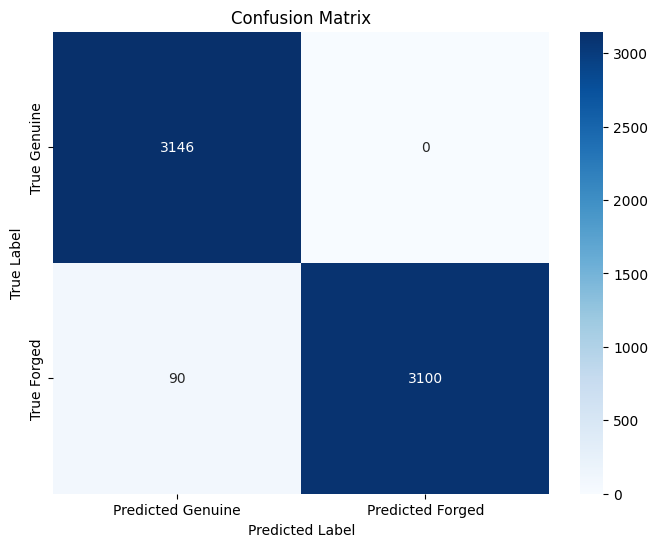

In [80]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Predicted Genuine', 'Predicted Forged'],
            yticklabels=['True Genuine', 'True Forged'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [82]:
def calculate_metrics(confusion_matrix):
  """
  Calculates precision, recall, and F1-score from a confusion matrix.

  Args:
    confusion_matrix: A numpy array representing the confusion matrix.

  Returns:
    A dictionary containing precision, recall, and F1-score for each class.
  """
  tp = confusion_matrix[0, 0]
  fp = confusion_matrix[0, 1]
  tn = confusion_matrix[1, 1]
  fn = confusion_matrix[1, 0]

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1_score = 2 * (precision * recall) / (precision + recall)

  if tp == 0:
    precision = 0
    recall = 0
    f1_score = 0

  metrics = {
      'precision': precision,
      'recall': recall,
      'f1_score': f1_score
  }

  return metrics

In [83]:
metrics = calculate_metrics(conf_matrix)

print("Precision:", metrics['precision'])
print("Recall:", metrics['recall'])
print("F1-Score:", metrics['f1_score'])

Precision: 1.0
Recall: 0.9721878862793573
F1-Score: 0.9858978376684424


#Single Predict Function

In [72]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Forged Signature")
    else:
        print("Genuine Signature")

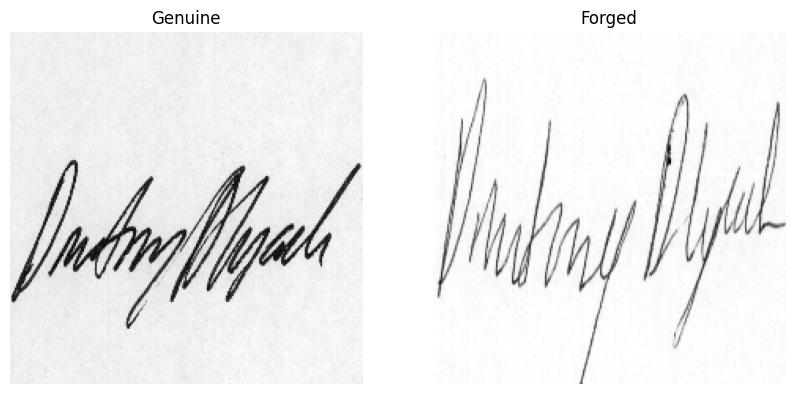

1/1 [==============================] - 0s 21ms/step
Difference Score =  0.032365963
Its a Forged Signature


In [74]:
predict_score()